<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%206/Assignment/Tensorflow_Deteksi_Sarkasme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import keras_tuner as kt
import requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


## Data Preparation

In [ ]:
# Ambil data mentah
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

# Pisahkan setiap baris, lalu decode masing-masing JSON
data = [json.loads(line) for line in response.text.split('\n') if line.strip()]

# Cek sampel
print("Jumlah data:", len(data))
print("Contoh data:", data[0])

Jumlah data: 26709
Contoh data: {'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [ ]:
sentences = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

In [ ]:
# Tokenisasi
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=100)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

## RNN dan Hyperparameter Tuning

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, hp.Int('embed_dim', 32, 128, step=32)))
    model.add(tf.keras.layers.SimpleRNN(hp.Int('rnn_units', 32, 128, step=32), return_sequences=False))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        metrics=['accuracy']
    )
    return model

# Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='sarcasm_rnn_tuner',
    project_name='simple_rnn_tuning'
)

tuner.search(X_train, np.array(y_train), epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 02m 44s]
val_accuracy: 0.7784277200698853

Best val_accuracy So Far: 0.8542349338531494
Total elapsed time: 00h 12m 11s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Train & Evaluasi

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.9080 - loss: 0.2377 - val_accuracy: 0.8519 - val_loss: 0.3578
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.9403 - loss: 0.1623 - val_accuracy: 0.8474 - val_loss: 0.3885
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.9632 - loss: 0.1076 - val_accuracy: 0.8300 - val_loss: 0.4247
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.9756 - loss: 0.0814 - val_accuracy: 0.8487 - val_loss: 0.4733
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9827 - loss: 0.0590 - val_accuracy: 0.8426 - val_loss: 0.4968
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.9867 - loss: 0.0458 - val_accuracy: 0.8418 - val_loss: 0.5847
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9874 - loss: 0.0409 - val_accuracy: 0.8383 - val_loss: 0.5789
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.9916 - loss: 0.0275 - 

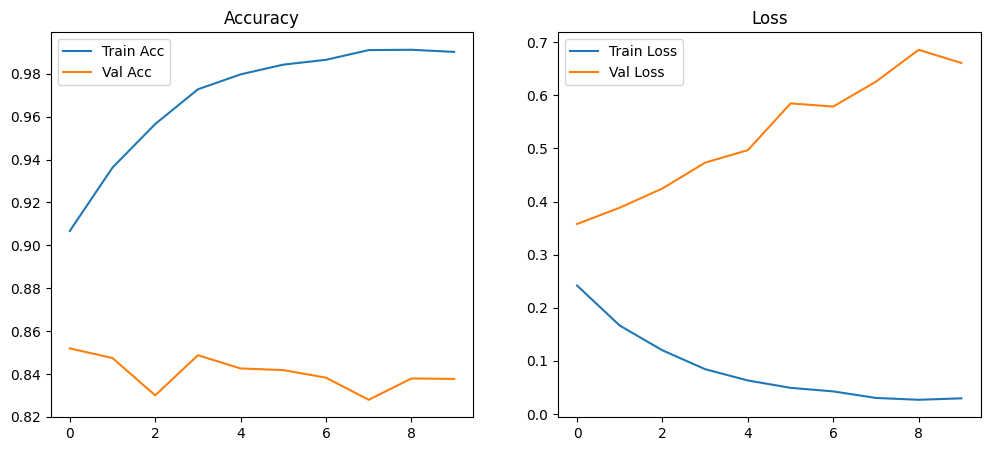

In [ ]:
history = best_model.fit(X_train, np.array(y_train), epochs=10, validation_data=(X_test, np.array(y_test)))

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Akurasi  : 0.8377
Presisi  : 0.8242
Recall   : 0.8014
F1-Score : 0.8126
AUC      : 0.9055


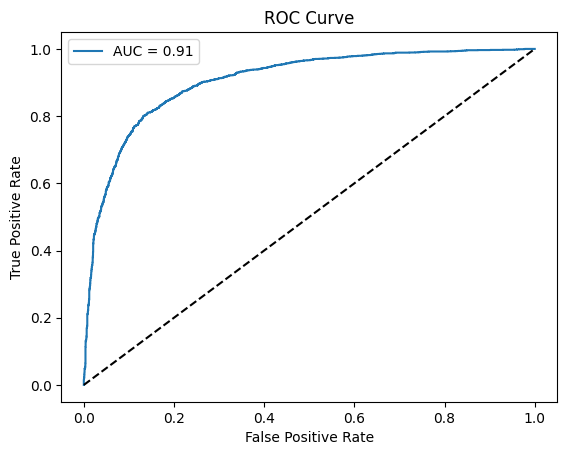

In [ ]:
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## LSTM Model

In [ ]:
# Fungsi untuk mendefinisikan model LSTM
def build_lstm_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=10000,
        output_dim=hp.Int('embed_dim', min_value=32, max_value=128, step=32),
        input_length=100
    ))
    model.add(tf.keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
        return_sequences=False
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', values=[1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

### Hyperparameter Tuning

In [ ]:
def clean_text(text):
    text = text.lower()  # Menjadikan semua huruf kecil
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Menghapus simbol/special character
    return text

# Pembersihan pada data
sentences = [clean_text(sentence) for sentence in sentences]

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences)

X = tokenizer.texts_to_sequences(sentences)
X = pad_sequences(X, maxlen=100)

# Split data menjadi train dan test
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter Tuning menggunakan RandomSearch
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='tuner_lstm',
    project_name='sarcasm_detection_lstm'
)

# Cari model terbaik
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_lstm_model = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 20m 54s]
val_accuracy: 0.8627854585647583

Best val_accuracy So Far: 0.8627854585647583
Total elapsed time: 00h 50m 45s


### Training & Evaluasi

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 197s 295ms/step - accuracy: 0.9656 - loss: 0.0966 - val_accuracy: 0.8538 - val_loss: 0.4267
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 202s 296ms/step - accuracy: 0.9811 - loss: 0.0559 - val_accuracy: 0.8502 - val_loss: 0.5661
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 195s 286ms/step - accuracy: 0.9894 - loss: 0.0330 - val_accuracy: 0.8478 - val_loss: 0.6958
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 208s 295ms/step - accuracy: 0.9936 - loss: 0.0210 - val_accuracy: 0.8409 - val_loss: 0.8655
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 207s 302ms/step - accuracy: 0.9954 - loss: 0.0147 - val_accuracy: 0.8433 - val_loss: 1.0651


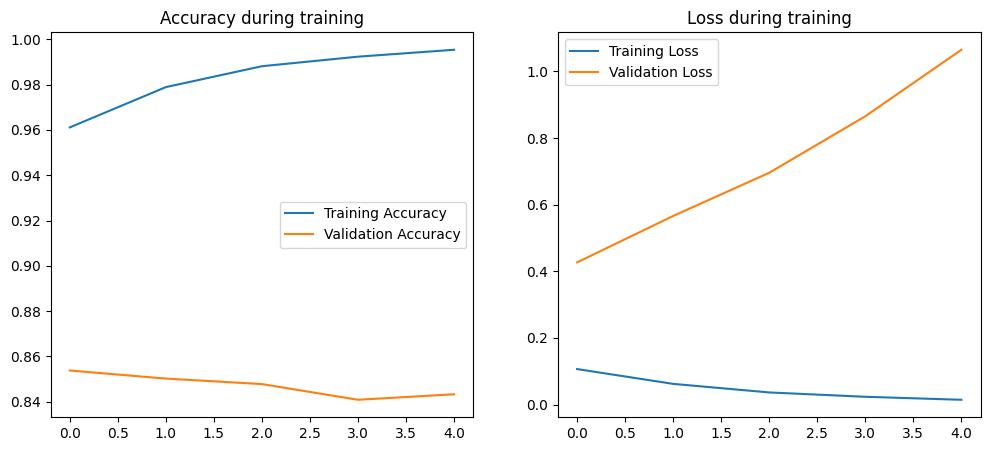

In [ ]:
# Training model terbaik
history = best_lstm_model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test)
)

# Visualisasi hasil training dan validation
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.legend()

plt.show()

167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
Akurasi  : 0.8433
Presisi  : 0.8633
Recall   : 0.7643
F1-Score : 0.8108
AUC      : 0.8950


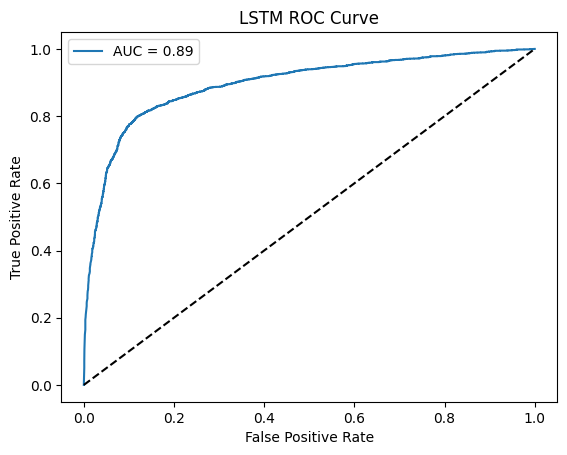

In [ ]:
y_pred_prob_lstm = best_lstm_model.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype("int32")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

acc = accuracy_score(y_test, y_pred_lstm)
prec = precision_score(y_test, y_pred_lstm)
rec = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)
auc = roc_auc_score(y_test, y_pred_prob_lstm)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lstm)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend()
plt.show()

## GRU Model

In [ ]:
def build_gru_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=10000,
        output_dim=hp.Int('embed_dim', min_value=32, max_value=128, step=32),
        input_length=100
    ))
    model.add(tf.keras.layers.GRU(
        units=hp.Int('gru_units', min_value=64, max_value=256, step=64),
        return_sequences=False
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

### Hyperparameter Tuning

In [ ]:
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='tuner_gru',
    project_name='sarcasm_detection_gru'
)

# Jalankan tuning
tuner_gru.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Ambil model terbaik
best_gru_model = tuner_gru.get_best_models(num_models=1)[0]

Trial 2 Complete [00h 06m 32s]
val_accuracy: 0.8597903251647949

Best val_accuracy So Far: 0.8603519201278687
Total elapsed time: 00h 28m 12s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Training & Evaluasi

In [ ]:
history_gru = best_gru_model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 247s 365ms/step - accuracy: 0.9304 - loss: 0.1944 - val_accuracy: 0.8628 - val_loss: 0.3712
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 270s 377ms/step - accuracy: 0.9358 - loss: 0.2770 - val_accuracy: 0.8531 - val_loss: 0.3803
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 247s 369ms/step - accuracy: 0.8454 - loss: 0.3981 - val_accuracy: 0.8566 - val_loss: 0.3687
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 250s 374ms/step - accuracy: 0.9472 - loss: 0.1403 - val_accuracy: 0.8502 - val_loss: 0.3969
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 261s 372ms/step - accuracy: 0.9568 - loss: 0.1216 - val_accuracy: 0.8433 - val_loss: 0.4308


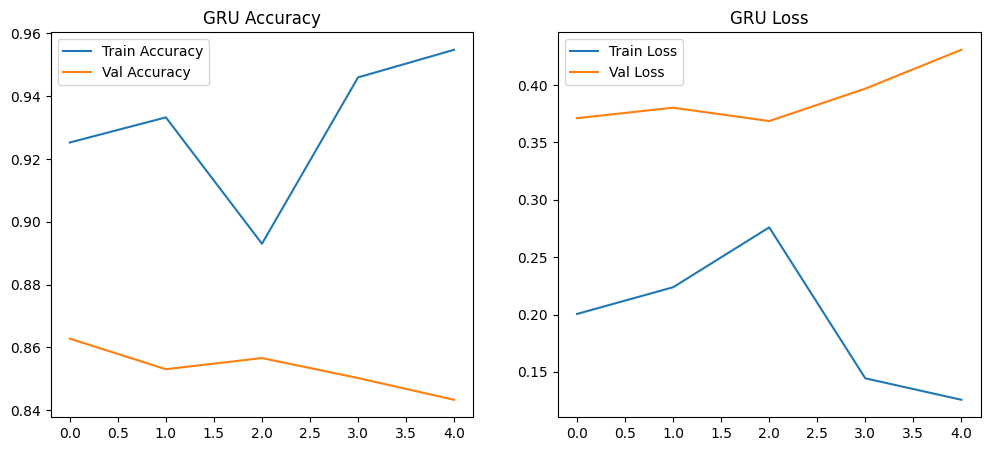

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Loss')
plt.legend()

plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step
GRU Accuracy : 0.8433
GRU Precision: 0.8228
GRU Recall   : 0.8197
GRU F1-Score : 0.8213
GRU AUC      : 0.9223


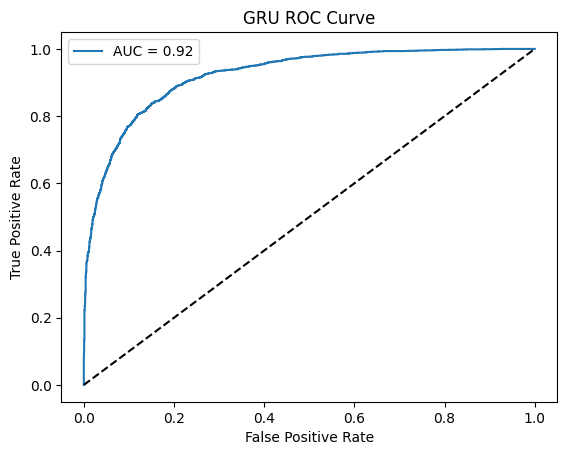

In [ ]:
y_pred_prob_gru = best_gru_model.predict(X_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype("int32")

acc_gru = accuracy_score(y_test, y_pred_gru)
prec_gru = precision_score(y_test, y_pred_gru)
rec_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)
auc_gru = roc_auc_score(y_test, y_pred_prob_gru)

print(f"GRU Accuracy : {acc_gru:.4f}")
print(f"GRU Precision: {prec_gru:.4f}")
print(f"GRU Recall   : {rec_gru:.4f}")
print(f"GRU F1-Score : {f1_gru:.4f}")
print(f"GRU AUC      : {auc_gru:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_gru)
plt.plot(fpr, tpr, label=f'AUC = {auc_gru:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GRU ROC Curve")
plt.legend()
plt.show()
